# Stable Diffusion on a GPU

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bacalhau-project/examples/blob/main/model-inference/stable-diffusion-gpu/index.ipynb)
[![Open In Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/bacalhau-project/examples/HEAD?labpath=model-inference/stable-diffusion-gpu/index.ipynb)

[Stable Diffusion](https://github.com/CompVis/stable-diffusion) is a state of the art text-to-image model that generates images from text and was developed as an open source alternative to [DALL·E 2](https://openai.com/dall-e-2/). It is based on a [Diffusion Probabilistic Model](https://arxiv.org/abs/2102.09672) and uses a [Transformer](https://arxiv.org/abs/1706.03762) to generate images from text.

This example demonstrates how to use stable diffusion on a GPU and run it on the [Bacalhau](https://www.bacalhau.org/) network. The first section describes the development of the code and the container. The section section demonstrates how to run the job using [Bacalhau](https://www.bacalhau.org/).

The following image is an example generated by this model.

### TL;DR

```bash
bacalhau docker run --gpu 1 ghcr.io/bacalhau-project/examples/stable-diffusion-gpu:0.0.1 -- python main.py --o ./outputs --p "cod swimming through data"
```
![](./image0.png)


## 1. Development

This stable diffusion example is based on the Keras/Tensorflow implementation of the model available [here](https://github.com/fchollet/stable-diffusion-tensorflow). You might also be interested in the Pytorch oriented [diffusers library](https://github.com/huggingface/diffusers).

### Prerequisites

In order to run this example you need:

* A Debian-flavoured Linux (although you [might be able](https://github.com/fchollet/stable-diffusion-tensorflow/blob/master/requirements_m1.txt) to get it working on M1 macs)
* [Docker](https://docs.docker.com/get-docker/)
* A GPU -- this was developed against a Tesla T4

In [1]:
%%bash
pip install git+https://github.com/fchollet/stable-diffusion-tensorflow --upgrade --quiet
pip install tensorflow tensorflow_addons ftfy --upgrade --quiet
pip install tqdm
apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 20 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 6s (66.2 MB/s)
(Reading database ... 123941 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching l

### Testing the Code

Quite often libraries aren't pinned, or code gets updated and breaks the docs, and even the simplest examples don't work. To derisk this, first I will try the code in the README to double check that the code is working as the author expected.

:::tip
When you run this code for the first time, it will download the pretrained weights, which may add a short delay.
:::

198152112/198152112 [==============================] - 1s 0us/step


  0   1: 100%|██████████| 50/50 [01:10<00:00,  1.42s/it]


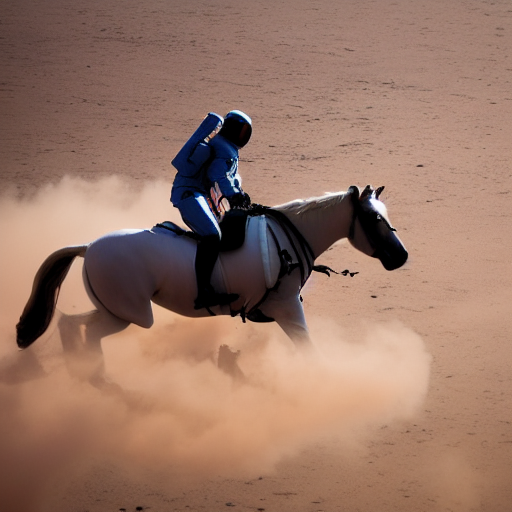

In [2]:
from stable_diffusion_tf.stable_diffusion import Text2Image
from PIL import Image

generator = Text2Image( 
    img_height=512,
    img_width=512,
    jit_compile=False,  # You can try True as well (different performance profile)
)
img = generator.generate(
    "DSLR photograph of an astronaut riding a horse",
    num_steps=50,
    unconditional_guidance_scale=7.5,
    temperature=1,
    batch_size=1,
)
pil_img = Image.fromarray(img[0])
display(pil_img)

That's great, it works! But it's used up all the GPU RAM.

:::tip
If you're interested, check the GPU RAM usage now you've run the code. You'll see that it's sucked up many GBs and depending on what GPU you're running, it may OOM if you run this again.

You can try and reduce RAM usage by playing with batch sizes (although it is only set to 1 above!) or more carefully controlling the tensorflow session.
:::

For now, let's ignore this and clear the GPU memory with numba so it works again next time. This won't be required when running in a single-shot manner.

In [5]:
%%bash
pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# clearing the GPU memory 
from numba import cuda 
device = cuda.get_current_device()
device.reset()

### Prepare a Script

You need a script to execute when we submit our job. The code below is functionally the same as above, but it also includes argument parsing to be able to customize the generator. This code is a slightly modified version of the [text2image.py script in the original repository](https://github.com/fchollet/stable-diffusion-tensorflow/blob/master/text2image.py).



In [23]:
%%writefile main.py
import argparse
from stable_diffusion_tf.stable_diffusion import Text2Image
from PIL import Image
import os
parser = argparse.ArgumentParser(description="Stable Diffusion")
parser.add_argument("--h",dest="height", type=int,help="height of the image",default=512)
parser.add_argument("--w",dest="width", type=int,help="width of the image",default=512)
parser.add_argument("--p",dest="prompt", type=str,help="Description of the image you want to generate",default="cat")
parser.add_argument("--n",dest="numSteps", type=int,help="Number of Steps",default=50)
parser.add_argument("--u",dest="unconditionalGuidanceScale", type=float,help="Number of Steps",default=7.5)
parser.add_argument("--t",dest="temperature", type=int,help="Number of Steps",default=1)
parser.add_argument("--b",dest="batchSize", type=int,help="Number of Images",default=1)
parser.add_argument("--o",dest="output", type=str,help="Output Folder where to store the Image",default="./")

args=parser.parse_args()
height=args.height
width=args.width
prompt=args.prompt
numSteps=args.numSteps
unconditionalGuidanceScale=args.unconditionalGuidanceScale
temperature=args.temperature
batchSize=args.batchSize
output=args.output

generator = Text2Image(
    img_height=height,
    img_width=width,
    jit_compile=False,  # You can try True as well (different performance profile)
)

img = generator.generate(
    prompt,
    num_steps=numSteps,
    unconditional_guidance_scale=unconditionalGuidanceScale,
    temperature=temperature,
    batch_size=batchSize,
)
for i in range(0,batchSize):
  pil_img = Image.fromarray(img[i])
  image = pil_img.save(f"{output}/image{i}.png")


Writing main.py


You should test that your script works! Let's run it again.

In [24]:
%%bash
python main.py

Process is interrupted.


Viewing the outputted image

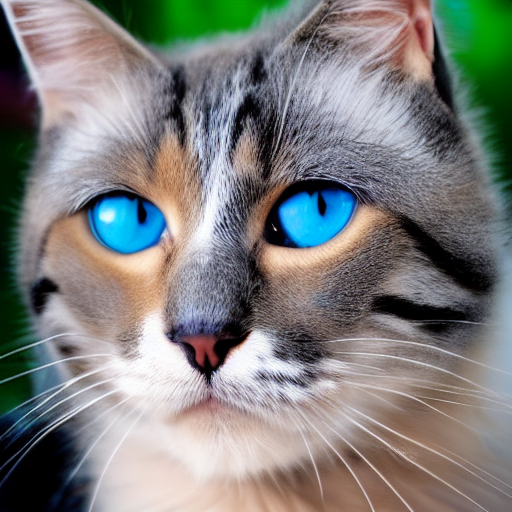

In [9]:
import IPython.display as display
display.Image("image0.png")

For reference, here is a full list of arguments that you can pass to the script.

```
optional arguments:
  -h, --help            show this help message and exit
  --h HEIGHT            height of the image
  --w WIDTH             width of the image
  --p PROMPT            Description of the image you want to generate
  --n NUMSTEPS          Number of Steps
  --u UNCONDITIONALGUIDANCESCALE
                        UNCONDITIONALGUIDANCESCALE
  --t TEMPERATURE       Temparature
  --b BATCHSIZE         Number of Images to generate
  --o OUTPUT            Output Folder where to store the Image
  ```



### Further Examples

The following presents some examples that you can try.

#### Prompt
```python stable-diffusion.py --p "cat with three eyes"```

#### Number of iterations
```
python stable-diffusion.py --p "cat with three eyes" --n 100
```
#### Batch Size (No of images to generate)
```
python stable-diffusion.py --p "cat with three eyes" --b 2
```


## 2. Running Stable Diffusion on Bacalhau with a GPU

Now we have a working example, we can convert it into a format that allows us to perform inference in a distributed environment.

First we will create a `Dockerfile` to containerize the inference code. 

```Dockerfile
FROM tensorflow/tensorflow:2.10.0-gpu

RUN apt-get -y update

RUN apt-get -y install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 git

RUN python3 -m pip install --upgrade pip

RUN python -m pip install regex tqdm Pillow tensorflow tensorflow_addons ftfy  --upgrade --quiet

RUN pip install git+https://github.com/fchollet/stable-diffusion-tensorflow --upgrade --quiet

ADD main.py main.py

# Run once so it downloads and caches the pre-trained weights
RUN python main.py --n 1
```

The dockerfile leverages the latest official tensorflow GPU image and then installs other dependencies like `git`, `CUDA` packages and other image related necessities. See [the original repository](https://github.com/fchollet/stable-diffusion-tensorflow/blob/master/requirements.txt) for the expected requirements.

:::tip
Note the last line, which runs the script once to trigger the download of the pretrained weights. This is necessary for Bacalhau, because Bacalhau jobs do not allow access to the internet.
:::

Build the container in the usual way. Replace the org/repo with your own if you are pushing to a custom registry.

```bash
docker buildx build --platform linux/amd64 --push -t ghcr.io/bacalhau-project/examples/stable-diffusion-gpu:0.0.1 .
```

In [10]:
!command -v bacalhau >/dev/null 2>&1 || (export BACALHAU_INSTALL_DIR=.; curl -sL https://get.bacalhau.org/install.sh | bash)
path=!echo $PATH
%env PATH=./:{path[0]}

Your system is linux_amd64
No BACALHAU detected. Installing fresh BACALHAU CLI...
Getting the latest BACALHAU CLI...
Installing v0.3.3 BACALHAU CLI...
Verified OK
Extracting tarball ...
NOT verifying Bin
bacalhau installed into . successfully.
Client Version: v0.3.3
Server Version: v0.3.3
env: PATH=./:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


### Generating an Image Using Stable Diffusion on a GPU using Bacalhau

[Bacalhau](https://www.bacalhau.org/) is a distributed computing platform that allows you to run jobs on a network of computers. It is designed to be easy to use and to run on a variety of hardware. In this example, we will use it to run the stable diffusion model on a GPU.

To submit a job, you can use the Bacalhau CLI. The following command passes a prompt to the model and generates an image in the outputs directory.

The main difference in the example below compared to all the other examples is the addition of the `--gpu X` flag, which tells Bacalhau to only schedule the job on nodes that have `X` GPUs free. You can [read more about GPU support](../../../next-steps/gpu) in the documentation. 

:::tip

This will take about 5 minutes to complete and is mainly due to the cold-start GPU setup time. This is faster than the CPU version, but you might still want to grab some fruit or plan your lunchtime run.

Furthermore, the container itself is about 10GB, so it might take a while to download on the node if it isn't cached.

:::

In [25]:
%%bash --out job_id
bacalhau docker run --id-only --gpu 1 ghcr.io/bacalhau-project/examples/stable-diffusion-gpu:0.0.1 -- python main.py --o ./outputs --p "meme about tensorflow"

In [26]:
%env JOB_ID={job_id}

env: JOB_ID=f126c9a5-0fd6-41c5-88e2-2d66a64a1317


Running the commands will output a UUID that represents the job that was created. You can check the status of the job with the following command:

In [27]:
%%bash
bacalhau list --id-filter ${JOB_ID}

 CREATED   ID        JOB                      STATE      VERIFIED  PUBLISHED               
 10:36:05  f126c9a5  Docker ghcr.io/bacal...  Completed            /ipfs/QmatWywziRqxTh... 



Where it says "`Completed `", that means the job is done, and we can get the results.

To find out more information about your job, run the following command:

In [28]:
%%bash
bacalhau describe ${JOB_ID}

APIVersion: V1alpha1
ClientID: 2e9bed59a71d1334f6576e314fa1e3e0fdb6a309396f33381fc5bf9ae1bcbf51
CreatedAt: "2022-10-19T10:36:05.655553494Z"
Deal:
  Concurrency: 1
ExecutionPlan:
  ShardsTotal: 1
ID: f126c9a5-0fd6-41c5-88e2-2d66a64a1317
JobState:
  Nodes:
    QmRjLYuFU1wAhWh3u94cm7DgbLRBTkUhCTAx77VyXBDgr4:
      Shards:
        "0":
          NodeId: QmRjLYuFU1wAhWh3u94cm7DgbLRBTkUhCTAx77VyXBDgr4
          PublishedResults:
            CID: QmatWywziRqxThuovctYRcPXPXJpcAWmJB56WyNwtRorWq
            Name: job-f126c9a5-0fd6-41c5-88e2-2d66a64a1317-shard-0-host-QmRjLYuFU1wAhWh3u94cm7DgbLRBTkUhCTAx77VyXBDgr4
            StorageSource: IPFS
          RunOutput:
            exitCode: 0
            runnerError: ""
            stderr: "0:13,  1.07s/it]\r 12 241:  74%|███████▍  | 37/50 [01:07<00:13,
              11 221:  76%|███████▌  | 38/50 [01:08<00:12,  1.07s/it]\r 11 221:  78%|███████▊
              \ | 39/50 [01:09<00:11,  1.07s/it]\r 10 201:  78%|███████▊  | 39/50
              [01:09<00:

If you see that the job has completed and there are no errors, then you can download the results with the following command:

In [29]:
%%bash
rm -rf results && mkdir -p results
bacalhau get $JOB_ID --output-dir results

Fetching results of job 'f126c9a5-0fd6-41c5-88e2-2d66a64a1317'...

2022/10/19 10:40:30 failed to sufficiently increase receive buffer size (was: 208 kiB, wanted: 2048 kiB, got: 416 kiB). See https://github.com/lucas-clemente/quic-go/wiki/UDP-Receive-Buffer-Size for details.


After the download has finished you should 
see the following contents in results directory

In [30]:
%%bash
ls results/volumes/outputs

image0.png


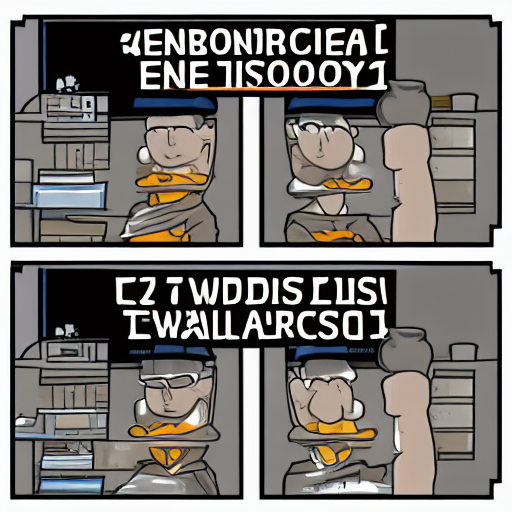

In [31]:
import IPython.display as display
display.Image("results/volumes/outputs/image0.png")